In [1]:
%load_ext autoreload
%autoreload 2

In [990]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from modules.StochasticProcess import StochasticProcess
from modules.ECGcleaner import ECGcleaner
from modules.QRSdetector import QRSdetector
from modules.ECGestimator import ECGestimator
from modules.Evaluator import Evaluator

In [1300]:
sp = "a03"
data_extension = ".csv"
gt_extension = ".fqrs.txt"
data_path = "../data/set-a-text"
results_path = "../results"

sp_path = os.path.join(data_path, sp+data_extension)
gt_path = os.path.join(data_path, sp+gt_extension)

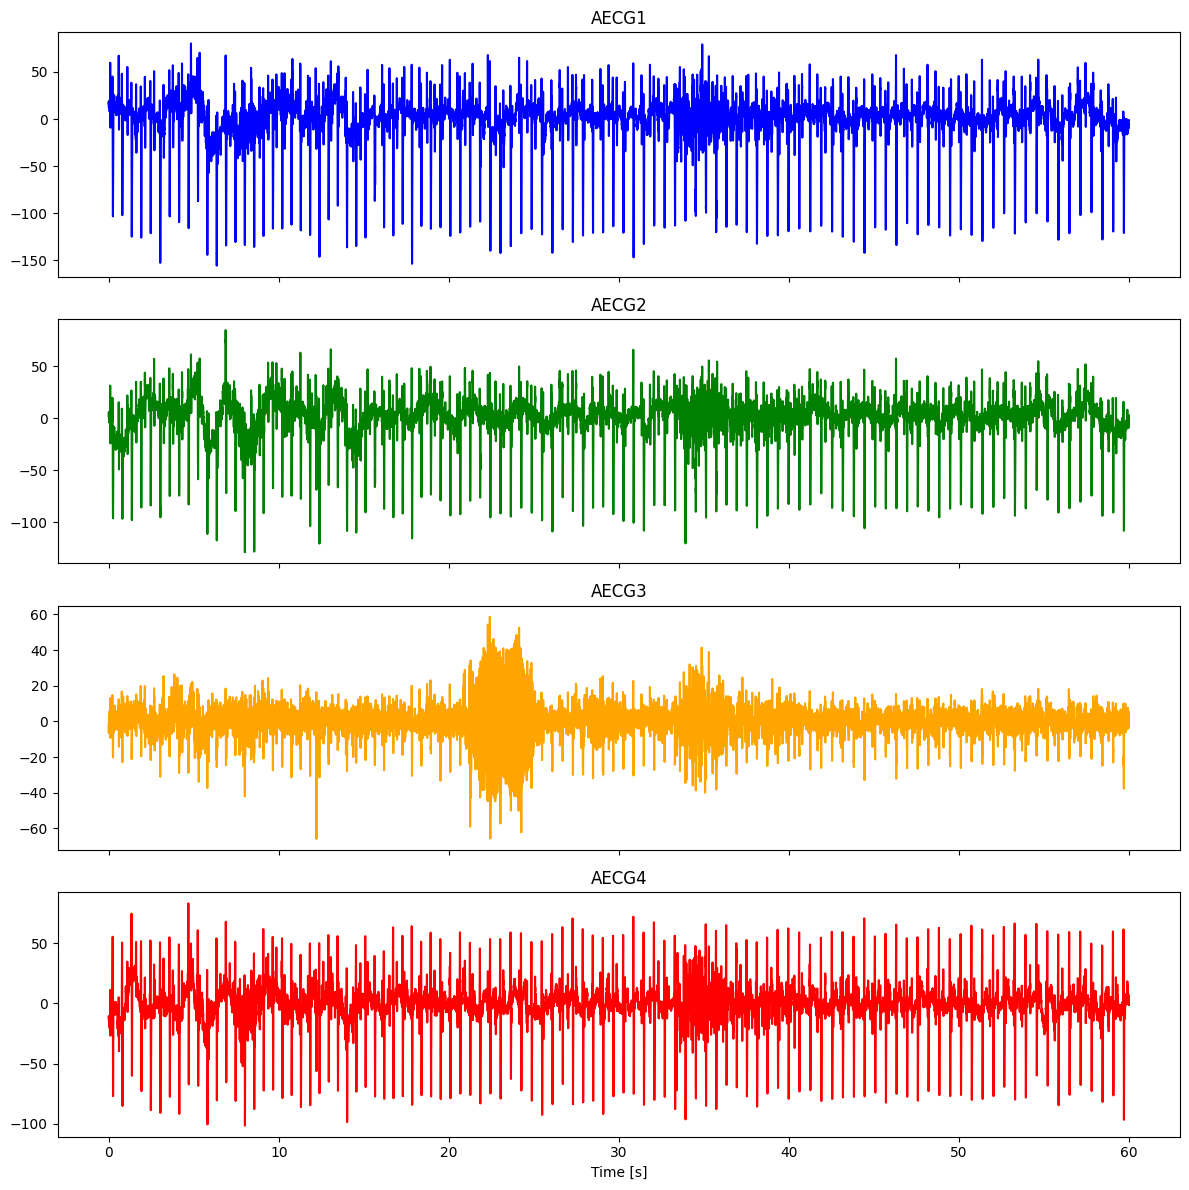

In [1301]:
def extract_stochastic_process(filename, num_realizations):
    df = pd.read_csv(filename, skiprows=2, header=None)
    realizations, labels = [], []
    for i in range (1,num_realizations+1):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        realizations.append(AECG_cleaned.astype(float))
        labels.append("AECG"+str(i))

    return realizations, labels

num_realizations = 4
realizations, labels = extract_stochastic_process(sp_path, num_realizations)
sr = 1000 
colors = ['blue', 'green', 'orange', 'red']

S1 = StochasticProcess(num_realizations, realizations, labels, colors, sr)
S1.plot()

# <b>Baseline Wander Remover</b>

In [1302]:
BW_freq = 3
BW_num_taps = 1000
PLI_freq = 50

ecg_cleaner = ECGcleaner(sr, BW_freq, PLI_freq)

S2 = StochasticProcess(num_realizations, [ecg_cleaner.remove_baseline_wander(r, BW_num_taps+1) for r in S1], labels, colors, sr)

# <b>Power-line interference canceller</b>

per ora troppo complicato, inoltre sembra che gli ECG del dataset abbiano già un filtraggio notch intorno ai 50 Hz per la rimozione della PLI. TODO:
- implementare il metodo ottimizzato proposto nel paper (top)
- implementare il metodo proposto dal paper, semplificato (accettabile)
- usare un notch filter a 50 Hz (brutto)

In [1303]:
notch_quality_factor = 30

S3 = StochasticProcess(num_realizations, [ecg_cleaner.remove_PLI_notch(r, notch_quality_factor) for r in S2], labels, colors, sr)

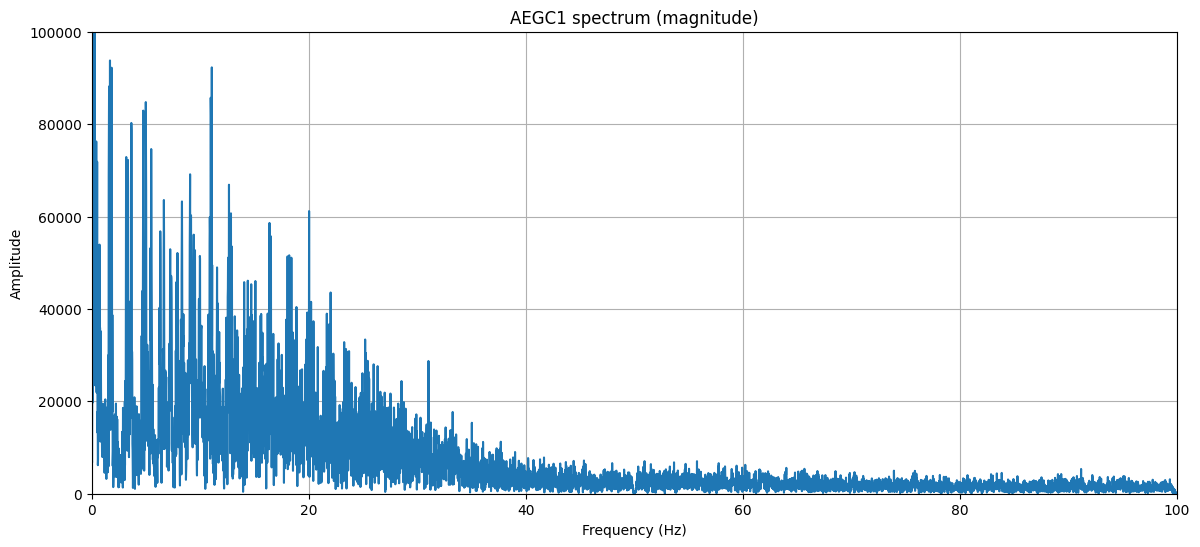

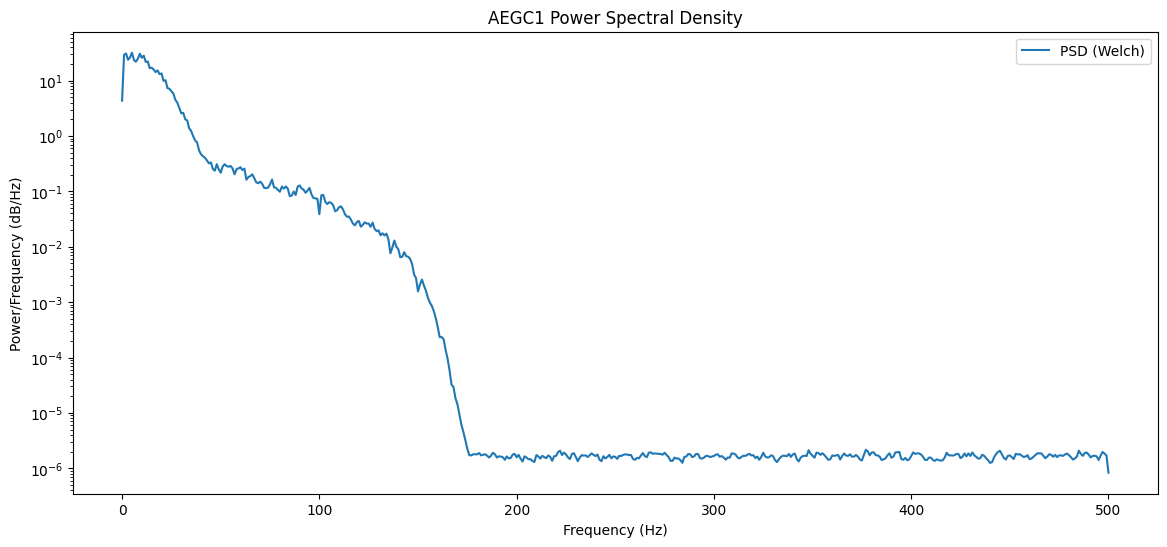

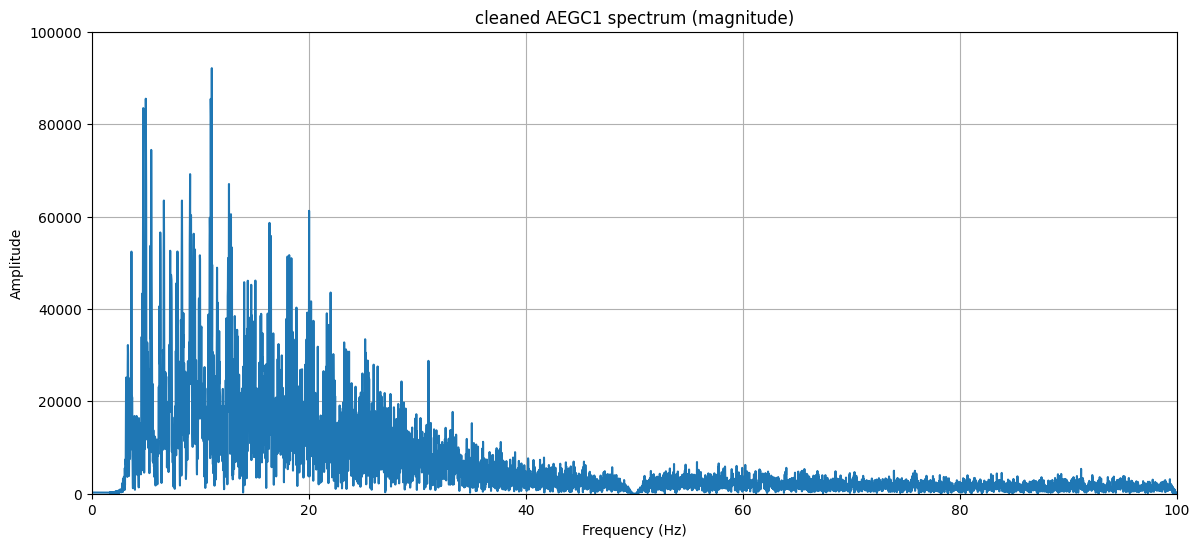

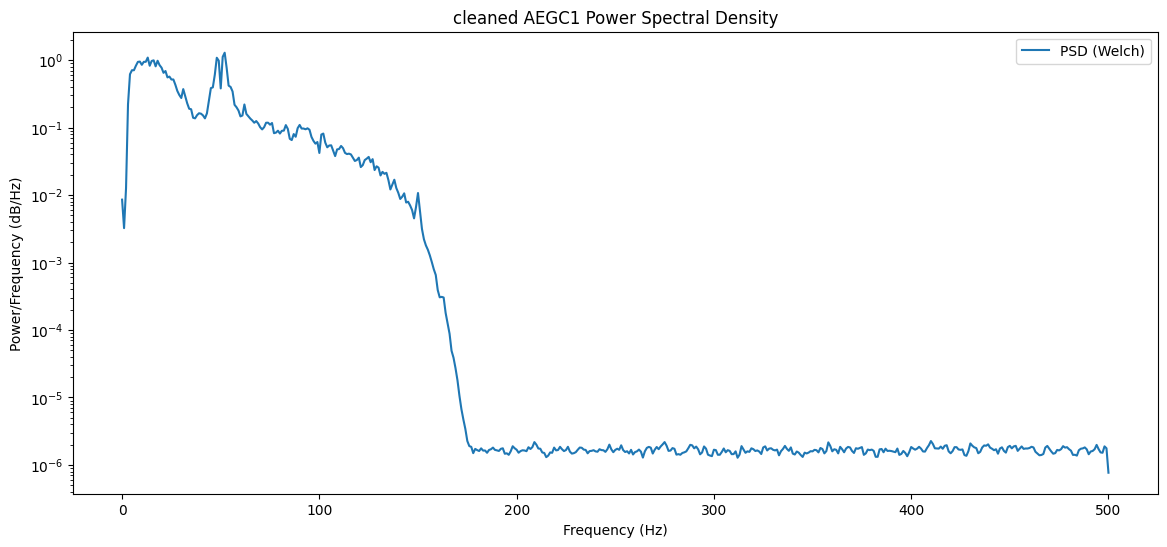

In [1304]:
S1.plot_realization_spectrum(0, "AEGC1 spectrum (magnitude)")
S1.plot_realization_PSD(0, 1000, "AEGC1 Power Spectral Density")

S3.plot_realization_spectrum(0, "cleaned AEGC1 spectrum (magnitude)")
S3.plot_realization_PSD(2, 1000, "cleaned AEGC1 Power Spectral Density")

# **Upsampling**

È sufficiente un upsampling 2X per ottenre la frequenza di campionamento utilizzata nel paper (2000 Hz)

In [1305]:
upsample_factor = 2
new_sr = sr * upsample_factor

S4 = S3.resample_process(new_sr)
#S4 = S2.resample_process(new_sr)
upsampled_time = S4.timestamps

# **Maternal QRS Detector**



### **1) QRS enhancement method**

L'idea è quella di sfruttare la forte correlazione tra le componenti QRS dei vari segnali e la bassa correlazione tra il rumore che li caratterizza, assumendo che ciascuna realizzazione del processo sia caratterizzata da queste due componenti.
Passaggi:

1. Normalizzazione dei canali, dividendo ciascun canale per la sua norma Euclidea
2. Applicazione della PCA sui canali
3. estrazione della prima componente come ECG con complessi QRS rafforzati

Questa procedura genera un segnale $\tilde{x}$ associato alla componente con maggiore varianza



In [1306]:
maternal_template_duration = 0.10
maternal_threshold_factor = 0.5

MQRS_detector = QRSdetector(S4, maternal_template_duration, maternal_threshold_factor, new_sr)
maternal_enhanced_QRS, maternal_explained_variance = MQRS_detector.get_enhanced_QRS()

Explained variance of PC1 (Maternal QRS): 70%


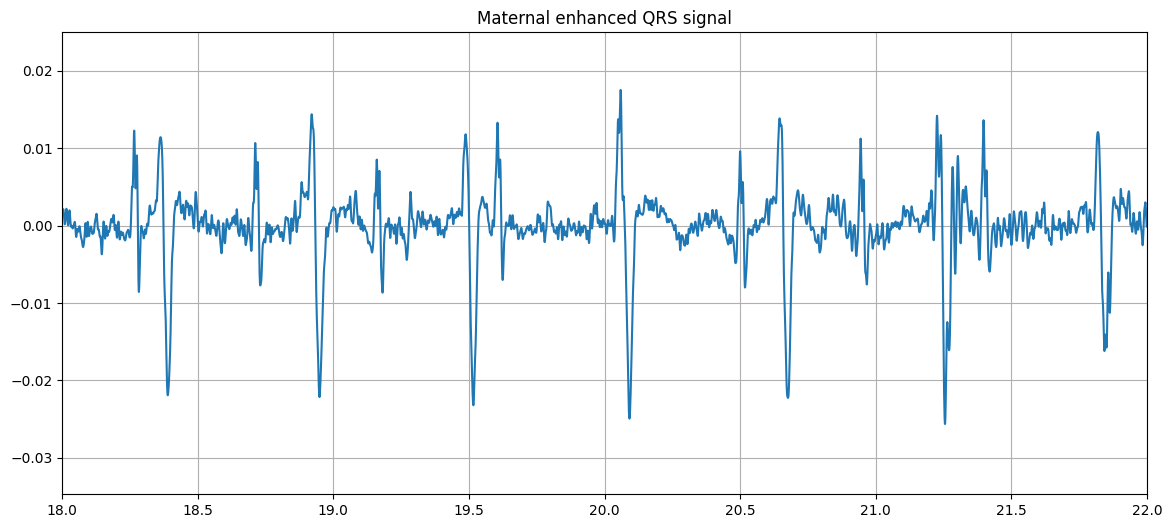

In [1307]:
print(f"Explained variance of PC1 (Maternal QRS): {round(maternal_explained_variance)}%")
plt.figure(figsize=(14, 6))
plt.plot(upsampled_time, maternal_enhanced_QRS)
plt.title('Maternal enhanced QRS signal')
plt.xlim(18, 22)
plt.grid(True)
plt.show()

### **2) QRS detection method**

L'idea qui è quella di usare un template QRS $h(t)$ e di calcolare la cross-correlazione $R_{\tilde{x},h}(τ)$ con il segnale $\tilde{x}$.

I massimi locali (picchi) di $R_{\tilde{x},h}(τ)$ saranno salvati in un vettore `R = [r1, r2, ... , rN]` che identificherà le N posizioni dei picchi QRS della madre

In [1308]:
maternal_qrs_template = MQRS_detector.create_qrs_template(maternal_enhanced_QRS)

Maternal QRS template length in samples: 200


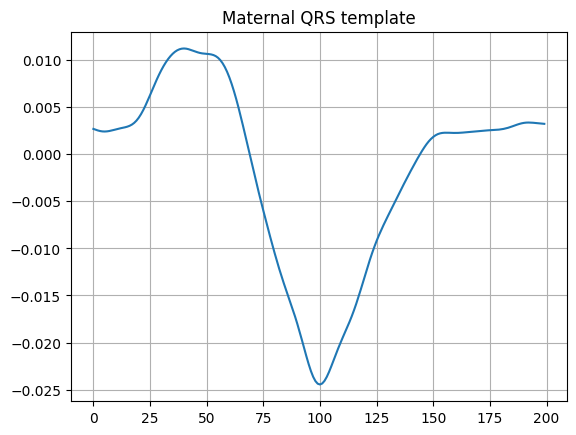

In [1309]:
print(f"Maternal QRS template length in samples: {len(maternal_qrs_template)}")
plt.plot(maternal_qrs_template)
plt.title('Maternal QRS template')
plt.grid(True)
plt.show()

In [1310]:
maternal_peaks, maternal_cross_corr = MQRS_detector.detect_qrs(maternal_enhanced_QRS, maternal_qrs_template)

QRS peaks detected: 101, with correlation threshold factor: 50 %


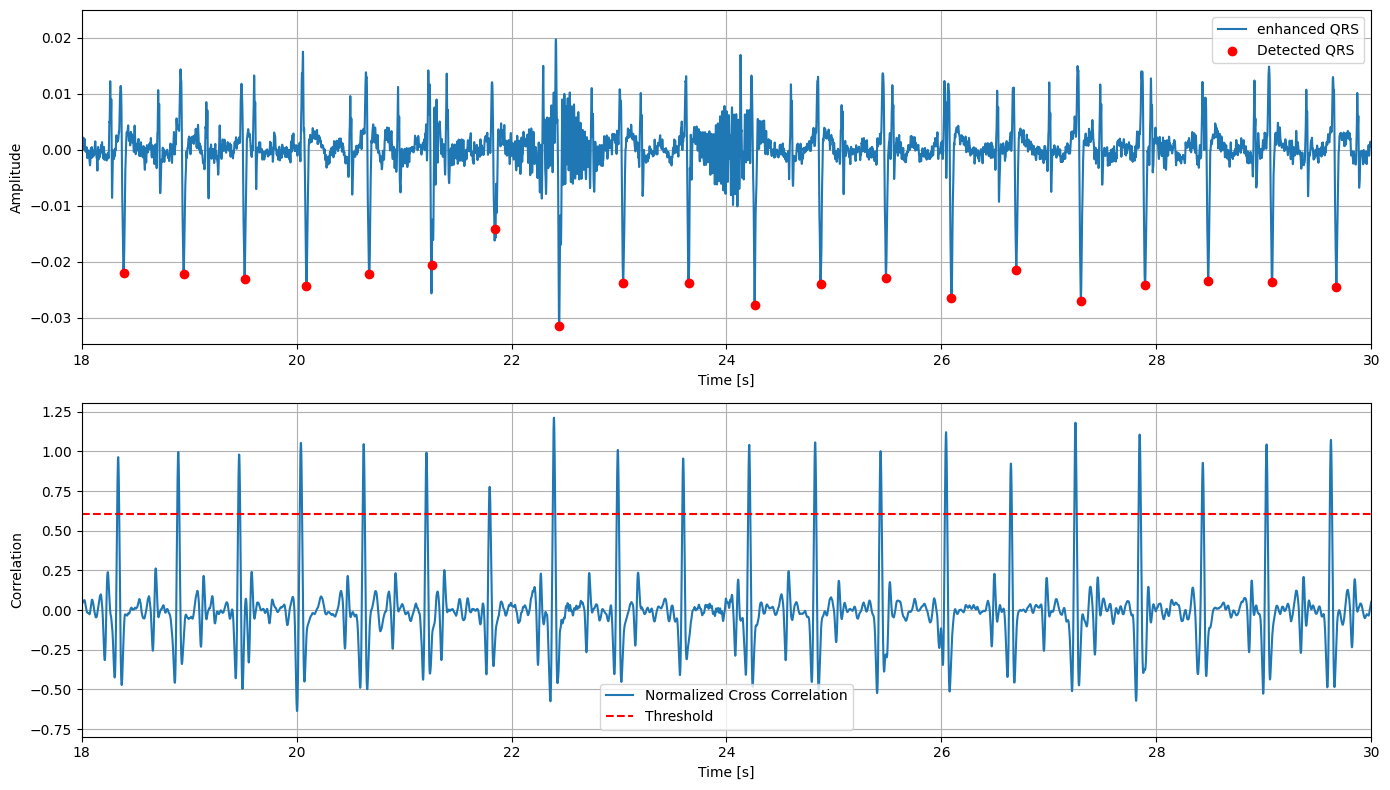

In [1311]:
def plot_correlation_data(cross_corr, peaks, gt_peaks, threshold_factor, time, enhanced_QRS, gt=False):
    corr_max = np.max(cross_corr)
    print(f"QRS peaks detected: {len(peaks)}, with correlation threshold factor: {round(threshold_factor*100)} %")
    if gt: print(f"QRS peaks (ground truth): {len(gt_peaks)}")
    
    plt.figure(figsize=(14, 8))

    # Enhanced QRS (with detected peaks)
    plt.subplot(2, 1, 1)
    plt.plot(time, enhanced_QRS, label="enhanced QRS")
    plt.scatter(time[peaks], enhanced_QRS[peaks], color='red', label="Detected QRS", zorder=2)
    if gt: plt.scatter(upsampled_time[gt_peaks], enhanced_QRS[gt_peaks], color='orange', label="Ground Truth QRS peaks", zorder=2)

    plt.legend()
    plt.xlabel("Time [s]")
    plt.xlim(18, 30)
    plt.ylabel("Amplitude")
    plt.grid()

    # Cross-correlation
    plt.subplot(2, 1, 2)
    plt.plot(time[:len(cross_corr)], cross_corr, label="Normalized Cross Correlation")
    plt.axhline(y=threshold_factor*corr_max, color='red', linestyle='--', label="Threshold")
    plt.legend()
    plt.xlim(18, 30)
    plt.xlabel("Time [s]")
    plt.ylabel("Correlation")
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_correlation_data(maternal_cross_corr, maternal_peaks, [], maternal_threshold_factor, upsampled_time, maternal_enhanced_QRS)

# **Maternal ECG Canceller**

Una porzione di MECG è definita nel seguente modo:
- *P wave:* 0.20 s
- *QRS complex:* 0.10 s
- *T wave:* 0.40 s


### **1) MECG identification**

L'MECG è identificato attraverso un metodo basato su finestratura: si costruisce una finestra centrata nel picco del complesso QRS secondo le caratteristiche sopra descritte.
La finestra avrà una durata di 1.40 s, di cui
- 0.25 prima del picco QRS
- 0.45 dopo il picco QRS

In [1312]:
maternal_P_wave_duration = 0.20
maternal_T_wave_duration = 0.40

MECG_estimator = ECGestimator(S4, maternal_P_wave_duration, maternal_template_duration, maternal_T_wave_duration, new_sr, labels)

In [1313]:
real_MECGs, real_MECGs_positions = MECG_estimator.get_real_ECGs(maternal_peaks)

### **2) Average MECG**

Sia $x$ il segnale di partenza, ovvero dato dalla somma di ECG materno, ECG fetale e rumore
Viene estratto un complesso MECG medio $μ$ effettuando la media sugli N complessi MECG estratti da $x$ attraverso finestratura.

In [1314]:
MECG_averages = MECG_estimator.get_ECG_averages(real_MECGs)

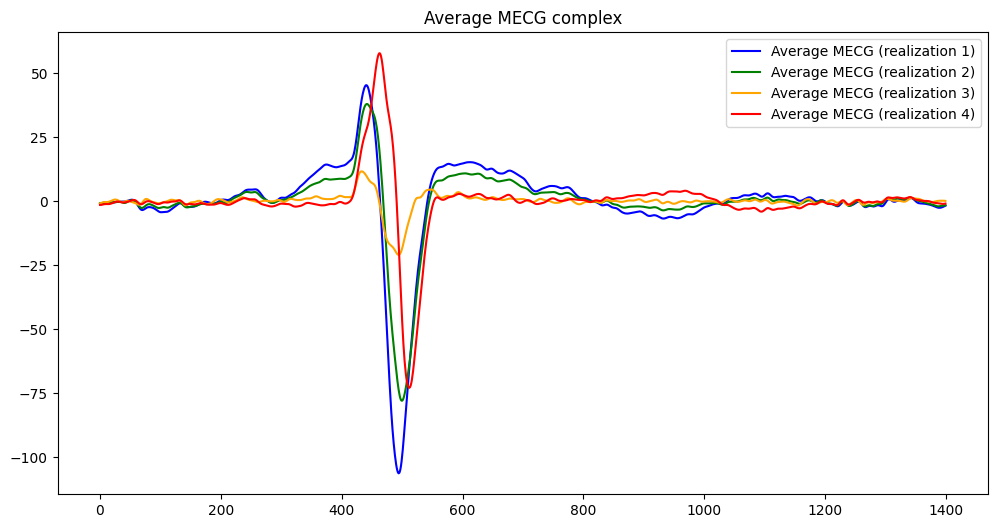

In [1315]:
plt.figure(figsize=(12, 6))
for i in range(num_realizations): plt.plot(MECG_averages[labels[i]], color=colors[i], label=f"Average MECG (realization {i+1})")
plt.legend()
plt.title("Average MECG complex")
plt.show()

### **3) MECG Scaling & Subtraction using MSE minimization**

L'MECG estratto $μ$ viene risuddiviso nelle sue tre componenti:
- $\mu_{QRS} →$ contiene il complesso QRS
- $\mu_P →$ contiene l'onda P
- $\mu_T →$ contiene l'onda T

L'idea è la seguente: per ogni complesso MECG appartenente ad $x$, $\mu_{QRS}$, $\mu_P$ e $\mu_T$ vengono oppurtunamente scalati attraverso tre distinti fattori, rispettivamente $a_{QRS}$, $a_P$ e $a_T$, in modo tale che il complesso MECG medio $\mu$ matchi esattamente con il complesso MECG reale $m$.

Facendo ciò si ottiene una stima più accurata del singolo complesso MECG. Questa stima, chiamata $\hat{m}$, è definita come segue:

\begin{align*}
    \hat{m} = Ma
\end{align*}

dove $a$ è l'array contenente i tre fattori di scaling
\begin{bmatrix}
a_P\\
a_{QRS}\\
a_T
\end{bmatrix}

e $M$ è una matrice quadrata 3x3 avente le tre componenti di $\mu$ sulla diagonale:

\begin{bmatrix}
\mu_P & 0 & 0\\
0 & \mu_{QRS} & 0\\
0 & 0 & \mu_T
\end{bmatrix}

Ora, dal momento che il sample rate a questo punto della procedura è pari a 2000 Hz:
- la lunghezza di $\mu_P$ è $0.20 s \times 2000 Hz = 400$ campioni
- la lunghezza di $\mu_{QRS}$ è $0.10 s \times 2000 Hz = 200$ campioni
- la lunghezza di $\mu_T$ è $0.40 s \times 2000 Hz = 800$ campioni

Dunque $M$ in versione esplicita può essere rappresentata come:

\begin{bmatrix}
\mu_P[0] & 0 & 0\\
\mu_P[1] & 0 & 0\\
... & 0 & 0\\
\mu_P[399] & 0 & 0\\
0 & \mu_{QRS}[0] & 0\\
0 & \mu_{QRS}[1] & 0\\
0 & ... & 0\\
0 & \mu_{QRS}[199] & 0\\
0 & 0 & \mu_T[0]\\
0 & 0 & \mu_T[1]\\
0 & 0 & ...\\
0 & 0 & \mu_T[799]\\
\end{bmatrix}


Per trovare $a$, viene minimizzato l'$MSE$ tra il complesso MECG stimato $\hat{m} = Ma$ e il reale complesso MECG $m$:

\begin{align*}
    \hat{a} = argmin_{a}||Ma - m||² = argmin_{a}(ϵ²)
\end{align*}

derivando e ponendo la il risultato della derivazione uguale a 0, si ottiene:

\begin{align*}
    \hat{a} = (M^TM)^{-1}M^Tm
\end{align*}

$\hat{a}$ conterrà i valori (scalari) di scaling associati alle tre componenti del complesso, che poi verranno moltiplicati per $\mu$ (componente per componente) in modo tale da ottenere il complesso ECG materno stimato $m$

In [1316]:
mu_portions = MECG_estimator.get_mu_portions(MECG_averages)

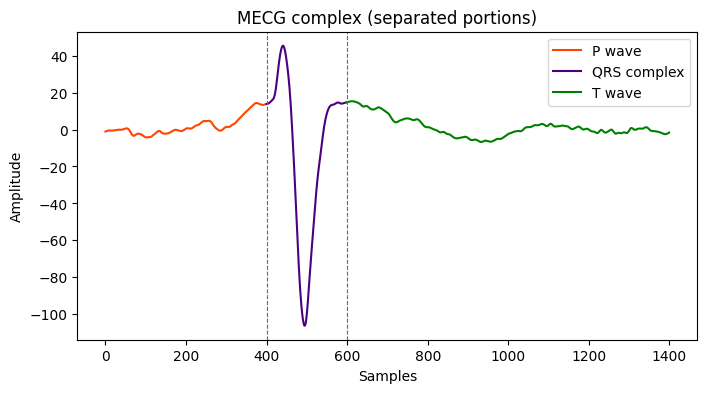

In [1317]:
# plot of the three portions of mu for a single realization, just as an example
mu = mu_portions["AECG1"]

x1 = np.arange(len(mu[0]))
x2 = np.arange(len(mu[1])) + len(mu[0])
x3 = np.arange(len(mu[2])) + len(mu[0]) + len(mu[1])

plt.figure(figsize=(8, 4))

plt.plot(x1, mu[0], label="P wave", color='orangered')
plt.plot(x2, mu[1], label="QRS complex", color='indigo')
plt.plot(x3, mu[2], label="T wave", color='green')

plt.axvline(len(mu[0]), color='dimgrey', linewidth=0.8, linestyle='--')
plt.axvline(len(mu[0]) + len(mu[1]), color='dimgrey', linewidth=0.8, linestyle='--')

plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("MECG complex (separated portions)")
plt.legend()
plt.show()

In [1318]:
M_matrixes = MECG_estimator.get_M_matrixes(mu_portions)

estimated_MECGs = MECG_estimator.get_estimated_ECGs(real_MECGs, M_matrixes, mu_portions)

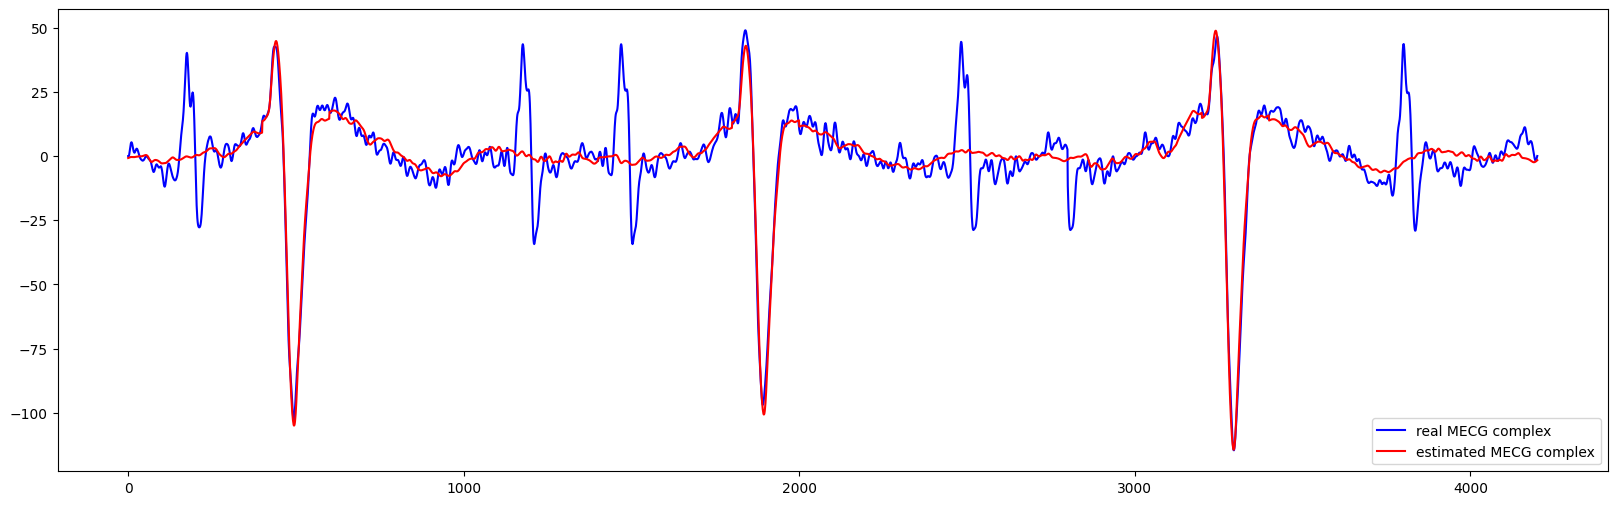

In [1319]:
# comparison between first three real (blue) and estimated (red) MECGs for the first realization, just as an example
channel = "AECG1"
first_three_reals_MECGs = np.concatenate([real_MECGs[channel][0], real_MECGs[channel][1], real_MECGs[channel][2]])
first_three_estimated_MECGs = np.concatenate([estimated_MECGs[channel][0], estimated_MECGs[channel][1], estimated_MECGs[channel][2]])

plt.figure(figsize=(20, 6))
plt.plot(first_three_reals_MECGs, color='blue', label="real MECG complex")
plt.plot(first_three_estimated_MECGs, color='red', label="estimated MECG complex")
plt.legend()
plt.show()

In [1320]:
residual_realizations = []

for i in range(num_realizations): 
    residual_realizations.append(MECG_estimator.cancel_ECG(S4.get_realization_by_index(i), real_MECGs_positions[labels[i]], real_MECGs[labels[i]], estimated_MECGs[labels[i]]))

S5 = StochasticProcess(num_realizations, residual_realizations, labels, colors, new_sr)

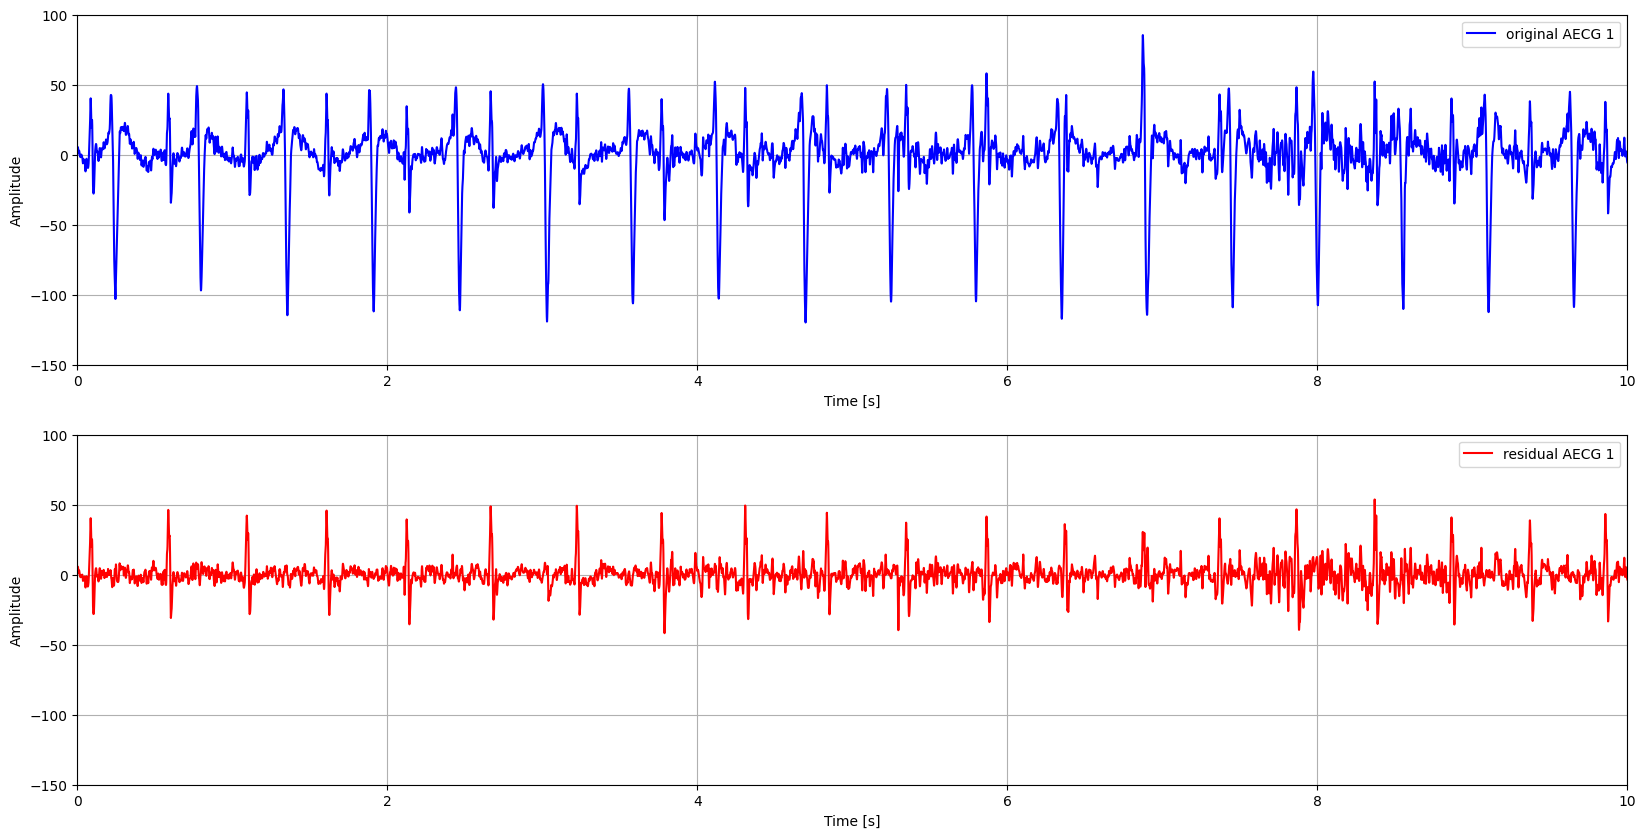

In [1321]:
# Comparison between the first original realization (MECG + FECG + noise) and the first residual realization (FECG + noise), just as an example
plt.figure(figsize=(20, 10))

index = 0

plt.subplot(2, 1, 1)
plt.plot(upsampled_time, S4.get_realization_by_index(index), color='blue', label="original AECG 1")
plt.legend()
plt.xlabel("Time [s]")
plt.xlim(0, 10)
plt.ylim(-150, 100)
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(upsampled_time, S5.get_realization_by_index(index), color='red', label="residual AECG 1")
plt.legend()
plt.xlabel("Time [s]")
plt.xlim(0, 10)
plt.ylim(-150, 100)
plt.ylabel("Amplitude")
plt.grid()

plt.show()

# **Fetal QRS Detector**

la procedura è la stessa usata per l'ECG materno:

processo stocastico → enhanced_QRS → QRS_template → correlazione tra QRS_template e enhanced_QRS

In [1322]:
# fetal peaks (ground truth)
with open(gt_path, 'r') as file: gt = np.array([int(line.strip()) for line in file])

# adapting to new sample rate
gt_fetal_peaks = gt * upsample_factor

In [1323]:
fetal_duration_template = 0.1
fetal_threshold_factor = 0.30

FQRS_detector = QRSdetector(S5, fetal_duration_template, fetal_threshold_factor, new_sr)

fetal_enhanced_QRS, fetal_explained_variance = FQRS_detector.get_enhanced_QRS()
print(f"Explained variance of PC1 (Fetal QRS) : {round(fetal_explained_variance)}%")

Explained variance of PC1 (Fetal QRS) : 71%


In [1324]:
fetal_QRS_template = FQRS_detector.create_qrs_template(fetal_enhanced_QRS)

Fetal QRS template length in samples: 200


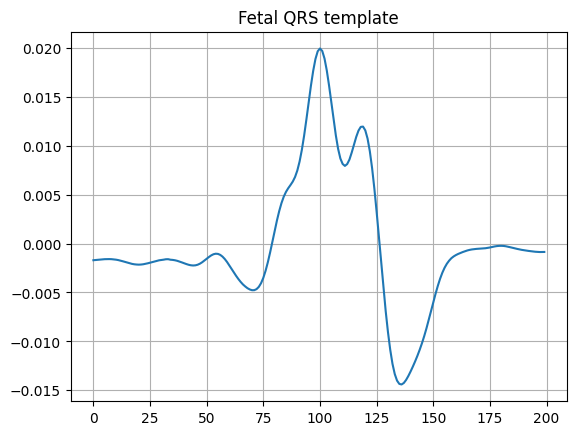

In [1325]:
print(f"Fetal QRS template length in samples: {len(fetal_QRS_template)}")
plt.plot(fetal_QRS_template)
plt.title('Fetal QRS template')
plt.grid(True)
plt.show()

In [1326]:
fetal_peaks, fetal_cross_corr = FQRS_detector.detect_qrs(fetal_enhanced_QRS, fetal_QRS_template)

QRS peaks detected: 126, with correlation threshold factor: 30 %
QRS peaks (ground truth): 128


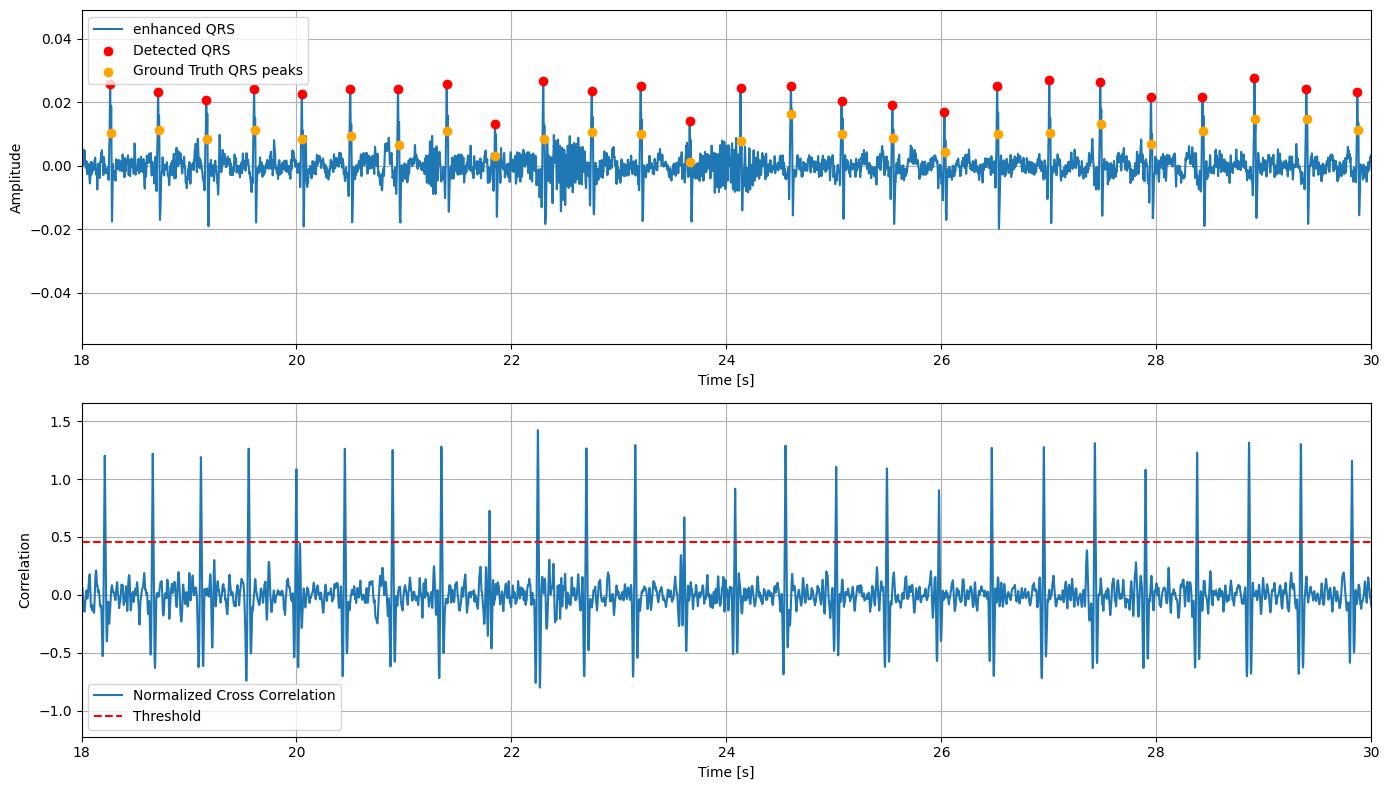

In [1327]:
plot_correlation_data(fetal_cross_corr, fetal_peaks, gt_fetal_peaks, fetal_threshold_factor, upsampled_time, fetal_enhanced_QRS, gt=True)

# **Fetal ECG Detector**

Il procedimento è lo stesso utilizzato sopra: una volta estrapolati i picchi vengono estratte le finestre associate ai complessi ECG fetali e vengono mediate, in modo tale da ottenere una stima del complesso ECG fetale per ciascuna realizzazione

In [1328]:
fetal_P_wave_duration = 0.20
fetal_T_wave_duration = 0.40

FECG_estimator = ECGestimator(S5, fetal_P_wave_duration, fetal_duration_template, fetal_T_wave_duration, new_sr, labels)

real_FECGs, _ = FECG_estimator.get_real_ECGs(fetal_peaks)
gt_FECGs, _ = FECG_estimator.get_real_ECGs(gt_fetal_peaks)

FECG_averages = FECG_estimator.get_ECG_averages(real_FECGs)
gt_FECG_averages = FECG_estimator.get_ECG_averages(gt_FECGs)

In [1329]:
S6 = StochasticProcess(num_realizations, [FECG_averages[label] for label in FECG_averages], labels, colors, new_sr)
gt_S6 = StochasticProcess(num_realizations, [gt_FECG_averages[label] for label in gt_FECG_averages], labels, colors, new_sr)

# **Metriche di valutazione**
Utilizzate per confrontare quanto, per ciascuna realizzazione, il complesso ECG fetale medio calcolato sui picchi QRS stimati si avvicina al complesso ECG fetale medio calcolato sui picchi QRS di ground truth. 

Con questo test si sta testando di fatto il metodo di rilevamento dei picchi QRS fetali, non la qualità del segnale fetale estratto. Si parte dunque assumendo che il segnale fetale estratto, S5, sia una buona stima del segnale fetale reale. Con questa assunzione, calcolando un complesso FECG medio usando come riferimento i complessi FECG centrati sui picchi di ground truth, si può considerare il complesso medio risultante, gt_S6, come una buona approssimazione del complesso FECG medio reale. 
A questo punto, la valutazione sta nel considerare quanto il complesso medio calcolato sui picchi stimati, S6, si avvicina ad gt_S6. In questo modo si valuta la qualità dell'estrazione dei picchi QRS fetali a partire dal segnale S5

La "vicinanza" tra S6 e gt_S6 è misurata attraverso:

- **Correlazione**: per avere una misura più qualitativa della forma dell'FECG
- **Errore quadratico medio**: valutare la differenza quantitativa in termini di ampiezza dei due complessi ECG

In [1330]:
evaluator = Evaluator(S6, gt_S6)

correlations, mean_correlation = evaluator.get_correlations()
MSEs, mean_MSE = evaluator.get_MSEs()

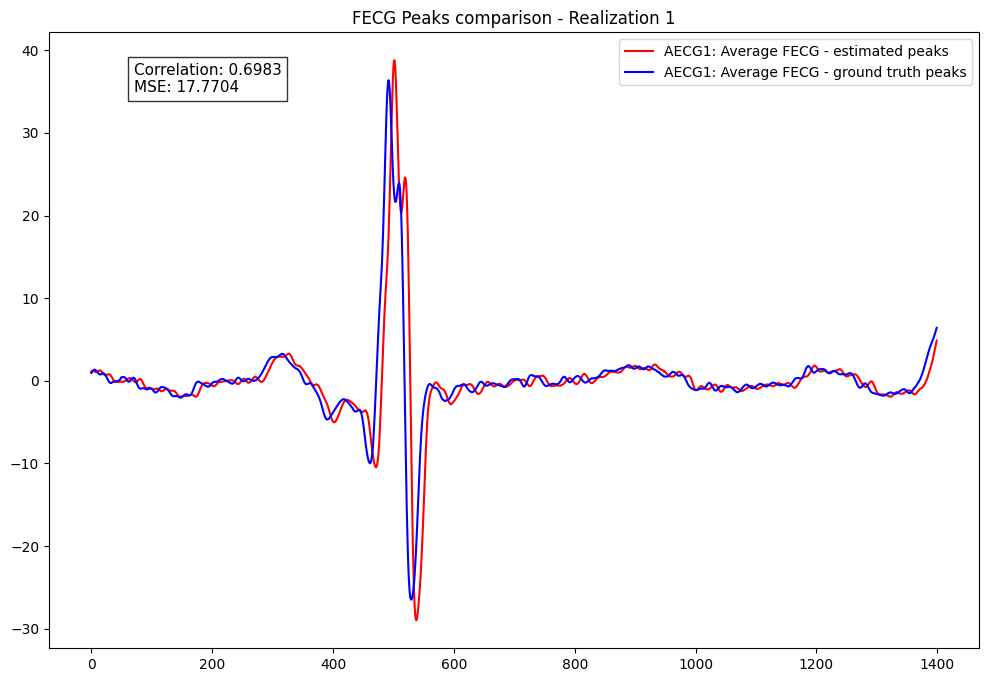

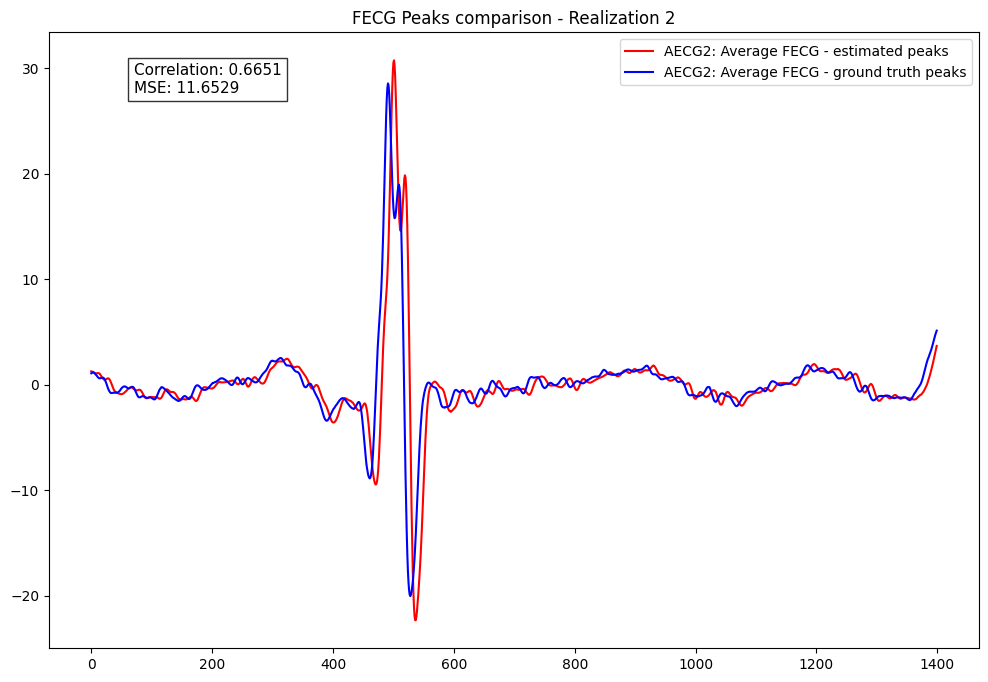

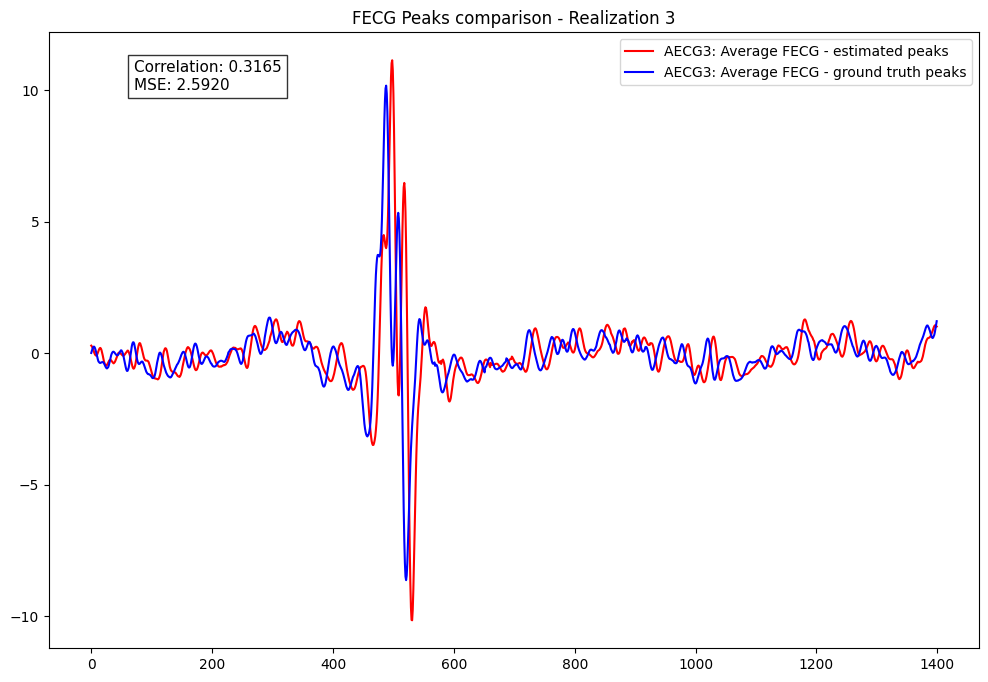

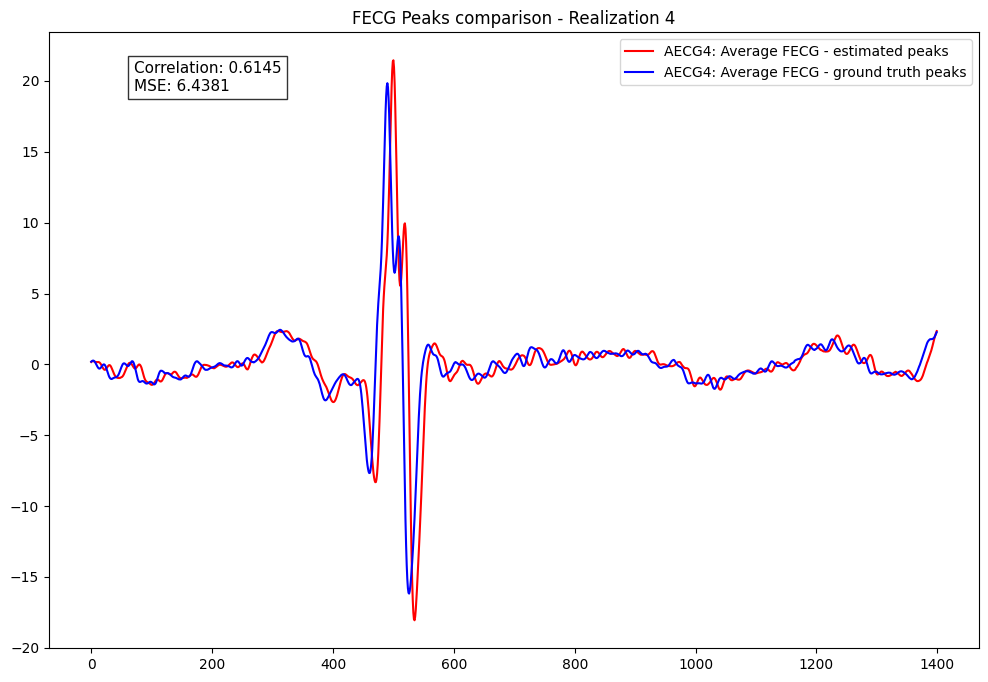

In [1331]:
evaluator.plot_comparison(correlations, MSEs, os.path.join(results_path, sp), plot=True, save=False)

In [1332]:
print(f"Average final correlation: {round(mean_correlation, 2)*100}%")
print(f"Average final MSE: {round(mean_MSE, 2)}")

Average final correlation: 56.99999999999999%
Average final MSE: 9.61
